In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install polars

In [ ]:
!pip install gensim==4.0.1

  Using cached gensim-4.0.1.tar.gz (23.1 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for gensim
  Running setup.py clean for gensim
Failed to build gensim
ERROR: Could not build wheels for gensim, which is required to install pyproject.toml-based projects


In [ ]:
from collections import defaultdict, Counter
from typing import List, Dict, Union
import pickle

from tqdm import tqdm
import numpy as np
import polars as pl
from gensim.models import Word2Vec

In [ ]:
DIR = "/content/drive/MyDrive/kddcup2023-ly/kddcup2023/"
TOP_N = 25
LOCALES = ["DE", "JP", "UK"]
VER = "05"
SEED = 42

In [ ]:
def preprocess(df:pl.DataFrame) -> pl.DataFrame:
    df = df.explode(["prev_items"])
    df = df.with_columns(
        df.select(pl.col("session_id").cumcount().over("session_id").alias("sequence_num"))
    )
    return df

In [ ]:
def train_word2vec(df:pl.DataFrame) -> Word2Vec:

    # Create a sequence of aids for each session
    aid_sequences = list(df.groupby("session_id", maintain_order=True).all()["prev_items"].to_list())

    # word2vec
    model = Word2Vec(
        sentences=aid_sequences,
        vector_size=128,
        epochs=25,
        min_count=1,
        workers=64,
        seed=SEED,
        sg=1,
        negative=5,
        window=5,
        sample=1e-3
    )

    return model

In [ ]:
def make_nns_matrix(w2v, k):
    aid_xs = []
    aid_ys = []
    sims = []
    for aid in tqdm(w2v.wv.index_to_key):
        nns = w2v.wv.most_similar(aid, topn=k)
        aid_y = [x[0] for x in nns]
        sim = [x[1] for x in nns]
        aid_xs.extend([aid] * k)
        aid_ys.extend(aid_y)
        sims.extend(sim)

    return pl.DataFrame({"item": aid_xs, "candidate_item": aid_ys, 'nns_similality': sims})

# For local train/eval

In [ ]:
train = pl.read_parquet(DIR + "data/preprocessed/task1/train_task1.parquet")
test1_1 = pl.read_parquet(DIR + "data/preprocessed/task1/test_task1_phase1.parquet")
test1_2 = pl.read_parquet(DIR + "data/preprocessed/task1/test_task1_phase2.parquet")
test2_1 = pl.read_parquet(DIR + "data/preprocessed/task2/test_task2_phase1.parquet").filter( pl.col("locale").is_in(LOCALES))
test2_2 = pl.read_parquet(DIR + "data/preprocessed/task2/test_task2_phase2.parquet").filter( pl.col("locale").is_in(LOCALES))
test3_1 = pl.read_parquet(DIR + "data/preprocessed/task3/test_task3_phase1.parquet").filter( pl.col("locale").is_in(LOCALES))
test3_2 = pl.read_parquet(DIR + "data/preprocessed/task3/test_task3_phase2.parquet").filter( pl.col("locale").is_in(LOCALES))
test1_1 = test1_1.with_columns(
    (pl.col("session_id") + "_from_task1").alias("session_id")
)
test1_2 = test1_2.with_columns(
    (pl.col("session_id") + "_from_task1").alias("session_id")
)
test3_1 = test3_1.with_columns(
    (pl.col("session_id") + "_from_task3").alias("session_id")
)
test3_2 = test3_2.with_columns(
    (pl.col("session_id") + "_from_task3").alias("session_id")
)
test = pl.concat([test1_1, test1_2, test2_1, test2_2, test3_1, test3_2])

In [ ]:
train = preprocess(train)
test = preprocess(test)
session_df = pl.concat([
    train[["prev_items", "locale", "session_id", "sequence_num"]],
    test[["prev_items", "locale", "session_id", "sequence_num"]],
])

<ipython-input-16-1bd84c2a05d5>:4: DeprecationWarning: `cumcount` is deprecated. It has been renamed to `cum_count`.
  df.select(pl.col("session_id").cumcount().over("session_id").alias("sequence_num"))


In [ ]:
df = session_df.filter(pl.col("locale") == "DE")

In [ ]:
df.head()

prev_items,locale,session_id,sequence_num
str,str,str,u32
"""B09W9FND7K""","""DE""","""train_0""",0
"""B09JSPLN1M""","""DE""","""train_0""",1
"""B076THCGSG""","""DE""","""train_1""",0
"""B007MO8IME""","""DE""","""train_1""",1
"""B08MF65MLV""","""DE""","""train_1""",2


In [ ]:
item_counts = df.groupby("prev_items").agg(pl.count("prev_items").alias("count"))
# Display the result
# Sort the result in descending order using the sort_by method
sorted_result = item_counts.sort("count", descending=True)
# Display the sorted result
sorted_result

<ipython-input-28-8d4b8b8818b8>:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  item_counts = df.groupby("prev_items").agg(pl.count("prev_items").alias("count"))


shape: (491_398, 2)
┌────────────┬───────┐
│ prev_items ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ B0BDML9477 ┆ 2630  │
│ B08GWS298V ┆ 2552  │
│ B0B1MPZWJG ┆ 1757  │
│ B07CZ4DLCP ┆ 1639  │
│ …          ┆ …     │
│ B0BF8TK3V5 ┆ 1     │
│ B01GD4ZPDI ┆ 1     │
│ B00QKRPLFQ ┆ 1     │
│ B09W9YFKDK ┆ 1     │
└────────────┴───────┘


ColumnNotFoundError: 

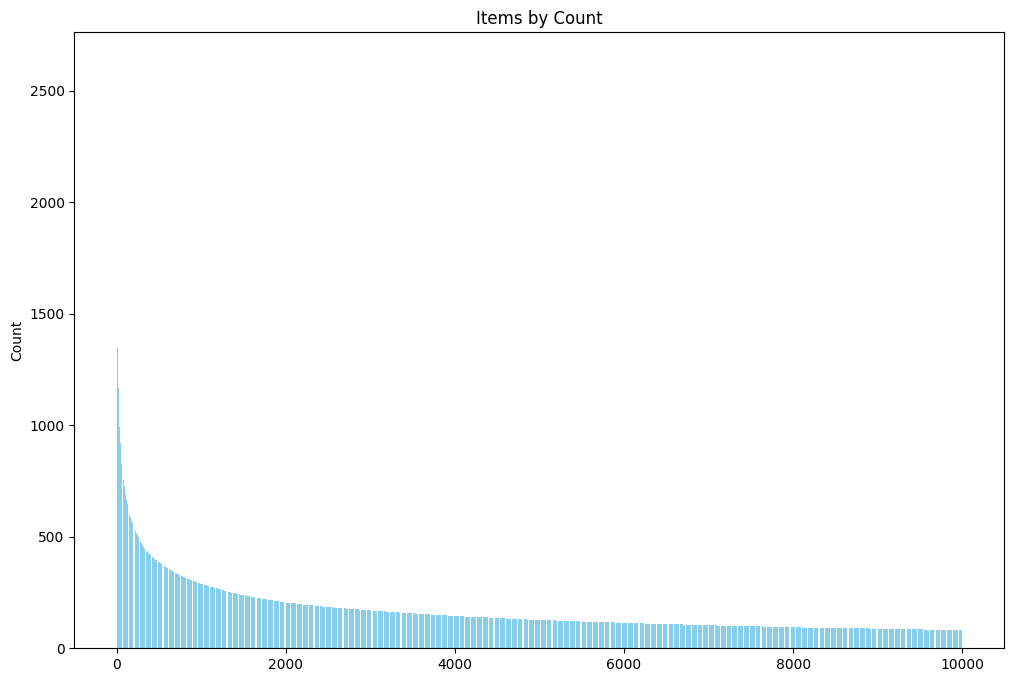

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Assuming sorted_result_pd is the converted Pandas DataFrame
# Select the top 100 rows
top_100 = sorted_result.head(10000)  # Select top 10000 rows for better visualization
plt.figure(figsize=(12, 8))  # Adjust figure size

# Plot a bar chart
plt.bar(range(len(top_100)), top_100['count'], color='skyblue')  # Use index as x-axis
plt.ylabel('Count')
plt.title('Items by Count')

# Set x-axis ticks
plt.xticks(range(len(top_100))[::100], top_100[''][::100], rotation=45, ha='right')  # Show every 100th label, rotated
plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming sorted_result is your Polars DataFrame sorted by 'count' in descending order
# Convert the Polars DataFrame to a Pandas DataFrame
sorted_result_pd = sorted_result.to_pandas()

# Select the top 10000 rows for better visualization
top_10000 = sorted_result_pd.head(10000)

# Create the bar plot using Matplotlib
plt.figure(figsize=(12, 8))  # Adjust figure size

# Plot a bar chart
plt.bar(range(len(top_10000)), top_10000['count'], color='skyblue')

# Set plot labels and title
plt.ylabel('Count')
plt.title('Items by Count (Top 10000)')

# Customize x-axis ticks to show every 100th label, rotated for readability
plt.xticks(range(len(top_10000))[::100], top_10000['prev_items'][::100], rotation=45, ha='right')

# Adjust the layout to prevent overlapping labels
plt.tight_layout()

# Display the plot
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7ef105a15120> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ef105a143a0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# Assuming sorted_result is your Polars DataFrame sorted by 'count' in descending order

# Convert the Polars DataFrame to a Pandas DataFrame
sorted_result_pd = sorted_result.to_pandas()

# Select the top 100 rows
top_100 = sorted_result_pd.head(100)

# Create a bar chart using Matplotlib
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
plt.bar(top_100['prev_items'], top_100['count'], color='skyblue')
plt.xlabel('Previous Items')
plt.ylabel('Count')
plt.title('Top 100 Previous Items by Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
# train word2vec model
for locale in tqdm(LOCALES):
    # filter by locale
    df = session_df.filter(pl.col("locale") == locale)

    # train and save word2vec model
    model = train_word2vec(df)
    model.save(DIR + f"models/task1/item2vec_{locale}_{VER}_for_train_or_eval.model")

  0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-10-8af742870e61>:4: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  aid_sequences = list(df.groupby("session_id", maintain_order=True).all()["prev_items"].to_list())
 33%|███▎      | 1/3 [04:26<08:52, 266.17s/it]<ipython-input-10-8af742870e61>:4: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  aid_sequences = list(df.groupby("session_id", maintain_order=True).all()["prev_items"].to_list())
 67%|██████▋   | 2/3 [08:28<04:12, 252.35s/it]<ipython-input-10-8af742870e61>:4: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  aid_sequences = list(df.groupby("session_id", maintain_order=True).all()["prev_items"].to_list())
100%|██████████| 3/3 [13:03<00:00, 261.06s/it]


## MRR@100

In [ ]:
train = pl.read_parquet("/content/drive/MyDrive/kddcup2023-ly/kddcup2023/data/preprocessed/task1/train_task1.parquet")

In [ ]:
# last_item get
last_item_list = []
prev_items_list = train["prev_items"].to_list()
for prev_items in prev_items_list:
    last_item_list.append(prev_items[-1])
train = train.with_columns(pl.Series(name="last_item", values=last_item_list))

In [ ]:
train = train[["session_id", "locale", "last_item", "next_item"]]

In [ ]:
nns_matrices = []
for locale in LOCALES:
    # calculate nearest neighbors
    w2v = Word2Vec.load(DIR + f"models/task1/item2vec_{locale}_{VER}_for_train_or_eval.model")
    nns_matrix = make_nns_matrix(w2v, TOP_N)
    nns_matrix = nns_matrix.with_columns(pl.lit(locale).alias("locale"))
    nns_matrices.append(nns_matrix)
nns_matrix = pl.concat(nns_matrices)

100%|██████████| 477221/477221 [1:54:20<00:00, 69.56it/s]


In [ ]:
file_name = f"nns_matrix_{VER}_for_train_or_eval.parquet"
nns_matrix.write_parquet("/content/drive/MyDrive/kddcup2023-ly/kddcup2023/data/interim/candidates/task1/" + file_name)

In [ ]:
train = train.join(nns_matrix, left_on=["locale", "last_item"], right_on=["locale", "item"], how="left")
train = train.sort(["session_id", "nns_similality"], descending=[False, True])
train = train.with_columns((pl.col("candidate_item") == pl.col("next_item")).cast(pl.Int8).alias("label"))
label_lists = train.groupby("session_id", maintain_order=True).all()["label"].to_list()

<ipython-input-24-01eaab9eb358>:4: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  label_lists = train.groupby("session_id", maintain_order=True).all()["label"].to_list()


In [ ]:
# MRR
rr = 0
for labels in label_lists:
    labels = labels[:100]
    for i, label in enumerate(labels):
        if label == 1:
            rr += 1 / (i+1)
            break
mrr = rr / len(label_lists)
print("MRR:", round(mrr, 5))

MRR: 0.16171
